In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def simulate_path(s0, mu, sigma, horizon, timesteps, n_sims, seed=None):
    if seed is not None:
        np.random.seed(seed)
    dt = horizon / timesteps
    S = np.zeros((timesteps, n_sims))
    S[0, :] = s0
    for i in range(1, timesteps):
        w = np.random.standard_normal(n_sims)
        S[i, :] = S[i-1, :] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * w)
    return S



In [3]:
def simulate_path_milstein(s0, mu, sigma, horizon, timesteps, n_sims, seed=None):
    if seed is not None:
        np.random.seed(seed)
    
    dt = horizon / timesteps  # Time step
    S = np.zeros((timesteps, n_sims))  # Initialize stock price matrix
    S[0, :] = s0  # Set initial stock price
    
    for i in range(1, timesteps):
        w = np.random.standard_normal(n_sims)  # Standard normal random variable
        dW = np.sqrt(dt) * w  # Brownian motion increment
        
        # Milstein correction term
        correction = 0.5 * sigma**2 * S[i-1, :] * (dW**2 - dt)
        
        # Apply the Milstein update
        S[i, :] = S[i-1, :] + mu * S[i-1, :] * dt + sigma * S[i-1, :] * dW + correction
    
    return S


<function __main__.simulate_path_milstein(s0, mu, sigma, horizon, timesteps, n_sims, seed=None)>

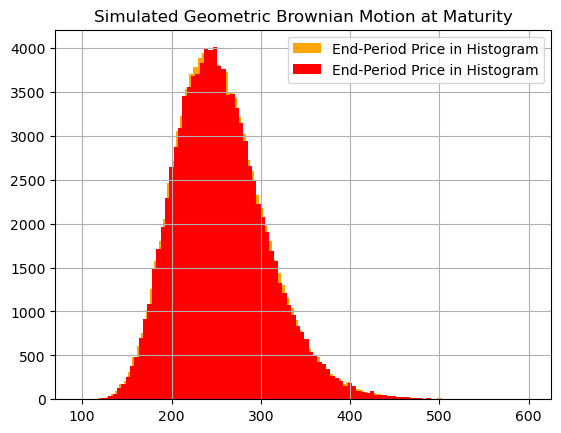

In [4]:
price_path = pd.DataFrame(simulate_path(242.95,0.05,0.2,1,252,100000))
# Plot the histogram of the simulated price path at maturity
price_path.iloc[-1].hist(bins=100, color='orange', label='End-Period Price in Histogram')
plt.legend()
plt.title('Simulated Geometric Brownian Motion at Maturity')

price_path = pd.DataFrame(simulate_path(242.95,0.05,0.2,1,252,100000))
# Plot the histogram of the simulated price path at maturity
price_path.iloc[-1].hist(bins=100, color='red', label='End-Period Price in Histogram')
plt.legend()
plt.title('Simulated Geometric Brownian Motion at Maturity')

simulate_path_milstein

In [26]:
def simulate_acdc(S0, r, sigma, T, N_paths, N_periods, days_per_year, m, K, B, G, contract='accumulator', seed=None):
    n_steps = int(days_per_year * T)
    #S = simulate_path(S0, r, sigma, T, n_steps, N_paths, seed)
    S = simulate_path_milstein(S0, r, sigma, T, n_steps, N_paths, seed)
    delta = 1 if contract.lower() == 'accumulator' else -1
    period_indices = np.linspace(0, n_steps, N_periods + 1, dtype=int)
    period_payoffs = np.zeros((N_paths, N_periods))
    for i in range(N_periods):
        start_index = period_indices[i]
        settlement_index = period_indices[i + 1] - 1
        X_i = np.zeros(N_paths)
        days_in_period = settlement_index - start_index + 1
        for day in range(days_in_period):
            for sim in range(N_paths):
                price = S[start_index + day, sim]
                if price < B:
                    if delta * (price - K) >= 0:
                        X_i[sim] += m
                    else:
                        X_i[sim] += G * m
                else:
                    X_i[sim] += 0
        S_settlement = S[settlement_index, :]
        A_i = delta * (S_settlement - K)
        period_payoff = X_i * A_i
        t_settlement = settlement_index / days_per_year
        discount_factor = np.exp(-r * t_settlement)
        #discount_factor = 0.995
        period_payoffs[:, i] = period_payoff * discount_factor
        
        # Print discount factor and the average discounted payoff for the period
        avg_payoff = np.mean(period_payoffs[:, i])
        print(f"Period {i+1}: t_settlement = {t_settlement*days_per_year:.3f} days, discount_factor = {discount_factor:.9f}, avg discounted payoff = {avg_payoff:.4f}")

    
    total_payoffs = np.sum(period_payoffs, axis=1)
    price = np.mean(total_payoffs)
    return price


In [30]:
if __name__ == '__main__':
    S0 = 214.945
    r = 0.0584
    sigma = 0.0
    T = 12/12
    days_per_year = 252
    N_periods = 12
    N_paths = 10000
    m = 1.0
    K = 214.945
    B = 1000.0
    G = 1
    contract_type = 'accumulator'
    
    price = simulate_acdc(S0, r, sigma, T, N_paths, N_periods, days_per_year, m, K, B, G, contract=contract_type, seed=100)
    print(f"Estimated price of the {contract_type} ACDC contract: {price:.4f}")


Period 1: t_settlement = 20.000 days, discount_factor = 0.995375804, avg discounted payoff = 20.8705
Period 2: t_settlement = 41.000 days, discount_factor = 0.990543410, avg discounted payoff = 42.6806
Period 3: t_settlement = 62.000 days, discount_factor = 0.985734477, avg discounted payoff = 64.3848
Period 4: t_settlement = 83.000 days, discount_factor = 0.980948890, avg discounted payoff = 85.9837
Period 5: t_settlement = 104.000 days, discount_factor = 0.976186537, avg discounted payoff = 107.4777
Period 6: t_settlement = 125.000 days, discount_factor = 0.971447304, avg discounted payoff = 128.8673
Period 7: t_settlement = 146.000 days, discount_factor = 0.966731079, avg discounted payoff = 150.1531
Period 8: t_settlement = 167.000 days, discount_factor = 0.962037751, avg discounted payoff = 171.3355
Period 9: t_settlement = 188.000 days, discount_factor = 0.957367208, avg discounted payoff = 192.4150
Period 10: t_settlement = 209.000 days, discount_factor = 0.952719340, avg discou